In [1]:
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf
import pandas as pd
import numpy as np

import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

###Import self-written library
import featexlib.debug as dbug
import featexlib.datagen as dgen

Data is ok
Out shape X,Y is: (200000, 84, 84) (200000,)
Number of classes: 10000
Max class label (should starts from 0): 9999
Show first 10 images:


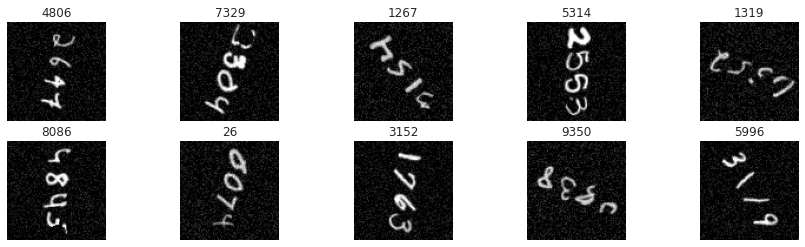

In [2]:
###Load data
###This cell should be used in another cell Can be used in another file

x_load, y_load = dgen.Image_generator.load_data(name="base_c20_84x84")

###Get information about dataset
y_uniq = len(np.unique(y_load))
y_max = y_load.max()

###Check if data is consistent
print("Data is ok" if (y_max+1)==y_uniq else "Data is NOT consistent! Y values should be from 0 to MAX, without gaps!!!")

###Show some report. Label is uniq for each class but it doesnt related to "real" image values
print("===================================")
print("Out shape X,Y is:",x_load.shape, y_load.shape)
print("Number of classes:",y_uniq)
print("Max class label (should starts from 0):", y_max)
print("Show first 10 images:")
dbug.Debug.show_images_list(x_load[:10], y_load[:10], col_number = 5)

In [3]:
###Split data to test and train
n_train = 100000
n_test = 2000

def relabel_y(inp_y):
    inp_y_uniq = len(np.unique(inp_y))
    inp_y_max = inp_y.max()

    print("Number of classes:",inp_y_uniq)
    print("Max class label:", inp_y_max)
    print("Relabeling is not required" if (inp_y_max+1)==inp_y_uniq else "Y should be relabeled to 0-n")

    if not (inp_y_max+1)==inp_y_uniq:
        lookup_table = dict(zip(np.unique(inp_y), np.arange(len(np.unique(inp_y)))) )
        vect_lookup = np.vectorize(lookup_table.get)
        out_y = np.copy(inp_y)
        out_y = vect_lookup(out_y)
        print("Y was relabeled")
        print("New number of classes:", len(np.unique(out_y)))
        print("New max class label:", out_y.max())
        return out_y
    else:
        return inp_y

###Get X train and test
x_train, x_test = x_load[:n_train], x_load[n_train:n_train+n_test]

###Relabel Y array to make it from 0 to n. Relabel test and train together!!!
y_train_test = relabel_y(y_load[:n_train+n_test])
y_train, y_test = y_train_test[:n_train], y_train_test[n_train:n_train+n_test]
num_classes = len(np.unique(y_train_test))

print("===============Data is ready====================")
print("Shape X,Y for train:",x_train.shape,y_train.shape)
print("Shape X,Y for test: ",x_test.shape,y_test.shape)
print("Number of classes is:",num_classes)

###Clean memory
del x_load, y_load

Number of classes: 10000
Max class label: 9999
Relabeling is not required
===============Data is ready====================
Shape X,Y for train: (100000, 84, 84) (100000,)
Shape X,Y for test:  (2000, 84, 84) (2000,)
Number of classes is: 10000


In [4]:
###Reshape and then rescale dataset
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(x_train.shape[0],-1))
x_test  = scaler.transform(x_test.reshape(x_test.shape[0],-1))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(100000, 7056) (100000,) (2000, 7056) (2000,)


In [5]:
###Prepare for training: check labels dimension (-1), change X to float32 instead of float64
ys = y_train.astype(int).reshape(-1)
xs = x_train.astype('float32')
#ys_one_hot = tf.one_hot(ys, num_classes) ###not used

ys_test = y_test.astype(int).reshape(-1)
xs_test = x_test.astype('float32')

###Clear memory
del x_train, y_train, y_test, x_test

In [7]:
###Model parameters
pic_h = 84
pic_w = 84
num_feat = 128
#'num_classes' is defined before

###Minimizer taken from tf library. Actually, this code is redundant and can be simplified
def _minimize(strategy, tape, optimizer, loss, trainable_variables):
    """Minimizes loss for one step by updating `trainable_variables`.
    This is roughly equivalent to
    ```python
    gradients = tape.gradient(loss, trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, trainable_variables))
    ```
    However, this function also applies gradient clipping and loss scaling if the
    optimizer is a LossScaleOptimizer.
    Args:
    strategy: `tf.distribute.Strategy`.
    tape: A gradient tape. The loss must have been computed under this tape.
    optimizer: The optimizer used to minimize the loss.
    loss: The loss tensor.
    trainable_variables: The variables that will be updated in order to minimize
    the loss.
    """

    with tape:
        if isinstance(optimizer, lso.LossScaleOptimizer):
            loss = optimizer.get_scaled_loss(loss)

    gradients = tape.gradient(loss, trainable_variables)

    # Whether to aggregate gradients outside of optimizer. This requires support
    # of the optimizer and doesn't work with ParameterServerStrategy and
    # CentralStroageStrategy.
    aggregate_grads_outside_optimizer = (
        optimizer._HAS_AGGREGATE_GRAD and  # pylint: disable=protected-access
        not isinstance(strategy.extended,
                       parameter_server_strategy.ParameterServerStrategyExtended))

    if aggregate_grads_outside_optimizer:
        # We aggregate gradients before unscaling them, in case a subclass of
        # LossScaleOptimizer all-reduces in fp16. All-reducing in fp16 can only be
        # done on scaled gradients, not unscaled gradients, for numeric stability.
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
                                                       trainable_variables))
    if isinstance(optimizer, lso.LossScaleOptimizer):
        gradients = optimizer.get_unscaled_gradients(gradients)
    gradients = optimizer._clip_gradients(gradients)  # pylint: disable=protected-access
    if trainable_variables:
        if aggregate_grads_outside_optimizer:
            optimizer.apply_gradients(
                zip(gradients, trainable_variables),
                experimental_aggregate_gradients=False)
        else:
            optimizer.apply_gradients(zip(gradients, trainable_variables))

###Model build in low level way
class Model(tf.keras.Model):
    def __init__(self, cl_coeff, dropout_rate = 0.1, variance_epsilon=1e-3, stddev = 0.1, bias = 0.1):
        super(Model, self).__init__()
        
        ###Model is Lenet++ taken from 'A Discriminative Feature Learning Approachfor Deep Face Recognition'
        ###Num features is 'num_feat'
        ###Num classes is 'num_classes'
        
        #Input pixel numbers is pic_h*pic_w*1
        input_shape = (-1,pic_h,pic_w,1)
        
        ###Weights initialisation for convolution layers should be sqrt(2/k*k*c) as in Kaiming He's, 'Delving Deep into Rectifiers...')
        ###because using PReLU as activation function for Conv layers
        conv_init = tf.keras.initializers.he_normal()
        #conv_init = tf.random_normal_initializer(mean=0.0, stddev=stddev, seed=None)
        
        ###Biases initialisation for convolution layers. Should be zeroes.
        conv_bias_init = 'zeros'
        #conv_bias_init = tf.constant_initializer(bias)

        ###Model layers
        #1,2: (5/32)/1,2 x 2 PReLU
        #3: MaxPool 2/2,0
        #4,5: (5/64)/1,2 x 2 PReLU
        #6: MaxPool 2/2,0
        #7,8: (5/128)/1,2 x 2 PReLU
        #9: MaxPool 2/2,0 + Dropout
        #10: FC*num_feat - feature vector
        #11: FC*num_classes - output
        
        self.conv1_1 = tf.keras.layers.Conv2D(32, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, input_shape=input_shape[1:])
        self.conv1_1_pr = self.get_conv_act(alpha=0.5)
        self.conv1_2 = tf.keras.layers.Conv2D(32, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv1_2_pr = self.get_conv_act(alpha=0.5)
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        self.conv2_1 = tf.keras.layers.Conv2D(64, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv2_1_pr = self.get_conv_act(alpha=0.3)
        self.conv2_2 = tf.keras.layers.Conv2D(64, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv2_2_pr = self.get_conv_act(alpha=0.3)
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        
        ###For last two convolution layers added L1L2 regularizer
        self.conv3_1 = tf.keras.layers.Conv2D(128, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.conv3_1_pr = self.get_conv_act(alpha=0.2)
        self.conv3_2 = tf.keras.layers.Conv2D(128, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.conv3_2_pr = self.get_conv_act(alpha=0.2)
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        
        self.pool3_drop = tf.keras.layers.Dropout(dropout_rate)
        
        self.feat = tf.keras.layers.Dense(num_feat, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.out = tf.keras.layers.Dense(num_classes)
        
        ###Batch normalisation is not used
        #self.bn_conv1_2 = tf.keras.layers.BatchNormalization()
        #self.bn_conv2_2 = tf.keras.layers.BatchNormalization()
        #self.bn_conv3_2 = tf.keras.layers.BatchNormalization()
        #self.bn_feat = tf.keras.layers.BatchNormalization()
        #self.bn_out = tf.keras.layers.BatchNormalization()
        
        #Make centers tf.constants - because we update them manually
        self.centers = tf.constant(tf.zeros([num_classes,num_feat], dtype=tf.float32), name="centers")
        self.cl_coeff = cl_coeff
        self.dropout_rate = dropout_rate
        self.variance_epsilon = variance_epsilon
    
    def get_conv_act(self, alpha = 0.2):
        #return tf.keras.layers.LeakyReLU(alpha=alpha)
        return tf.keras.layers.PReLU(alpha_initializer = tf.constant_initializer(alpha))
    
    def get_regularizer(self,l1=0.01,l2=0.01):
        return tf.keras.regularizers.L1L2(l1=l1, l2=l2)
    
    def __call__(self, x, training=False):
        x_reshaped = tf.reshape(x, [-1,pic_h,pic_w,1])
        h_conv1_1 = self.conv1_1(x_reshaped)
        h_conv1_1_pr = self.conv1_1_pr(h_conv1_1)
        h_conv1_2 = self.conv1_2(h_conv1_1_pr)
        h_conv1_2_pr = self.conv1_2_pr(h_conv1_2)
        h_pool1 = self.pool1(h_conv1_2_pr)
        #h_pool1_bn = self.bn_conv1_2(h_pool1, training = training)
        
        tf.print("W Conv1 var:",tf.nn.moments(h_conv1_2,axes=[0,1,2,3])[1])
        
        h_conv2_1 = self.conv2_1(h_pool1)
        h_conv2_1_pr = self.conv2_1_pr(h_conv2_1)
        h_conv2_2 = self.conv2_2(h_conv2_1_pr)
        h_conv2_2_pr = self.conv2_2_pr(h_conv2_2)
        h_pool2 = self.pool2(h_conv2_2_pr)
        #h_pool2_bn = self.bn_conv2_2(h_pool2, training = training)
        
        tf.print("W Conv2 var:",tf.nn.moments(h_conv2_2,axes=[0,1,2,3])[1])
        
        h_conv3_1 = self.conv3_1(h_pool2)
        h_conv3_1_pr = self.conv3_1_pr(h_conv3_1)
        h_conv3_2 = self.conv3_2(h_conv3_1_pr)
        h_conv3_2_pr = self.conv3_2_pr(h_conv3_2)
        h_pool3 = self.pool3(h_conv3_2_pr)

        tf.print("W Conv3 var:",tf.nn.moments(h_conv3_2,axes=[0,1,2,3])[1])
        
        h_pool3_flt = tf.reshape(h_pool3, [-1,h_pool3.shape[1]*h_pool3.shape[2]*h_pool3.shape[3]])  #tf.reshape(h_pool3, self.get_flat_shape(h_pool3))
        #h_pool3_bn = self.bn_conv3_2(h_pool3_flt, training = training)
        
        h_pool3_flt_drop = self.pool3_drop(h_pool3_flt,training = training)

        h_feat = self.feat(h_pool3_flt_drop)
        
        tf.print("W Fc1   var:",tf.nn.moments(h_feat,axes=[0,1])[1])
        
        #features = self.bn_out(features, training = training)
        y_out = self.out(h_feat)
        
        #In case of library losses use softmax output
        return y_out, h_feat   #tf.nn.softmax(y_out)
    
    def set_center_loss_coeff(self, cl_coeff):
        self.cl_coeff = cl_coeff
    
    def get_center_loss(self, features, labels):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(tf.stop_gradient(self.centers), labels)
        center_loss = tf.reduce_sum(input_tensor=(features - centers_batch) ** 2, axis=[1])
        return center_loss

    def centers_update(self, features, labels, alpha):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(self.centers, labels)
        diff = centers_batch - features

        unique_label, unique_idx, unique_count = tf.unique_with_counts(labels)
        appear_times = tf.gather(unique_count, unique_idx)
        appear_times = tf.reshape(appear_times, [-1, 1])

        diff = diff / tf.cast((1 + appear_times), tf.float32)
        diff = alpha * diff
        
        label_reshaped = tf.reshape(labels,[-1,1])
        
        self.centers = tf.tensor_scatter_nd_sub(self.centers, label_reshaped, diff)
        
    def get_losses(self, x, y, training=False):
        y_pred, h_features = self(x, training=training)
        return self._get_losses(y, y_pred, h_features)

    def _get_losses(self, y, y_pred, h_features):
        y_one_hot = tf.one_hot(y, num_classes)
        center_loss = self.get_center_loss(h_features, y)
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_one_hot), logits=y_pred)
        tf.print("Using loss with center loss coeff:", self.cl_coeff)
        loss = tf.reduce_mean(input_tensor=(softmax_loss + self.cl_coeff * center_loss)) #    
        return loss, softmax_loss, center_loss
    
    def get_accuracy(self, x, y):
        y_pred, _ = self(x, training=False)
        result = tf.argmax(input=y_pred,axis=1)
        ground_truth = tf.reshape(y, [-1])
        correct_prediction = tf.equal(result, ground_truth)
        accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))
        return accuracy
    
    def get_centers(self):
        return self.centers
    
    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)

        with backprop.GradientTape() as tape:
            y_pred, h_features = self(x, training=True)
            ###Calculate centerloss but don't include it in loss function
            loss, softmax_loss, center_loss = self._get_losses(y, y_pred, h_features) 
            #Default loss cant be used...
            #loss = self.compiled_loss(y, y_pred, sample_weight, regularization_losses=self.losses)
        
        ###Simple optimiser, not used.
        #trainable_variables = self.trainable_variables
        #gradients = tape.gradient(loss, trainable_variables)
        #self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
                  self.trainable_variables)
        
        ###Update center loss    
        self.centers_update(h_features, y, 0.5) 
        
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
        
        #trace output
        tf.print({m.name: m.result() for m in self.metrics})
        
        return {m.name: m.result() for m in self.metrics}
    
    def save_model(self, name, save_dir = "models"):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        self.save_weights(os.path.join(save_dir, name))

    def load_model(self, name, load_dir = "models"):
        self.load_weights(os.path.join(load_dir, name))
        
#Not used here, because can't implement center loss
class Softmax_and_center_loss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_true), logits=y_pred)
        loss = tf.reduce_mean(input_tensor=softmax_loss ) 
        return loss

#Helpful function to control center loss during training    
def center_loss_progress(n_prog,n_iter, koeff):
    return koeff*(n_prog+1)/(n_iter) if n_prog<n_iter else koeff    


In [8]:
###Train model with centerloss 0.1 dropout 0.15, batch size 256, 20 epochs (center loss needs more). Train/test accuracy = ...
model = Model(0.1, dropout_rate = 0.15, variance_epsilon=1e-3, stddev = 0.01, bias = 0.1)
model_loss = Softmax_and_center_loss()
opt = tf.keras.optimizers.Adam()#learning_rate=1e-4
bunch_len = 256
model.compile(opt, loss=model_loss, metrics=["accuracy"])

dataset = tf.data.Dataset.from_tensor_slices((xs, ys))
dataset_batches = dataset.batch(bunch_len)

n_epochs = 3
n_center_loss_progress = 5

for i in range(n_epochs):
    tf.print("Step #"+str(i))
    #loss, softmax_loss, center_loss = model.get_losses(xs, ys)
    #tf.print('Accuracy: ', model.get_accuracy(xs, ys))
    #tf.print('=== Full loss   :', loss)
    #tf.print('=== Softmax loss: ', softmax_loss)
    #tf.print('=== Center loss : ', tf.reduce_mean(center_loss))
    #tf.print('Centers: ', model.get_centers())
    for batch in dataset_batches:    
        model.set_center_loss_coeff(center_loss_progress(i,n_center_loss_progress,0.1))
        model.train_step(batch)
        
print("====================================================")
#print("Final accuracy should be discovered manually")
#print("Final train Accuracy:", model.get_accuracy(xs, ys))        
#print("Final test Accuracy:", model.get_accuracy(xs_test, ys_test))     

Step #0
W Conv1 var: 2.39241838
W Conv2 var: 4.54780436
W Conv3 var: 6.75913334
W Fc1   var: 12.1026344
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 2.04516959
W Conv2 var: 3.53772
W Conv3 var: 1.73461854
W Fc1   var: 26.4222069
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 1.76495242
W Conv2 var: 2.71540904
W Conv3 var: 2.04246116
W Fc1   var: 28.1483727
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 1.59769142
W Conv2 var: 2.22497845
W Conv3 var: 1.05131602
W Fc1   var: 87.2432175
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 1.55041611
W Conv2 var: 1.47436631
W Conv3 var: 0.709951222
W Fc1   var: 1.00056505
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 1.48826349
W Conv2 var: 1.38128483
W Conv3 var: 0.973558784
W Fc1   var: 1.9584291
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 1.47662294
W Conv2 var: 1.47835565
W Conv3 var: 1.03172302
W Fc1   va

W Fc1   var: 0.0522038899
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 1.20220935
W Conv2 var: 0.884523034
W Conv3 var: 0.324495375
W Fc1   var: 0.0472812578
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 1.17581248
W Conv2 var: 0.86718744
W Conv3 var: 0.316651046
W Fc1   var: 0.0443768166
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 1.19972348
W Conv2 var: 0.879012
W Conv3 var: 0.329235852
W Fc1   var: 0.0478824452
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 1.1681571
W Conv2 var: 0.860080779
W Conv3 var: 0.303907961
W Fc1   var: 0.0478631184
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 1.19097745
W Conv2 var: 0.867374301
W Conv3 var: 0.32080406
W Fc1   var: 0.0433415174
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 1.1702075
W Conv2 var: 0.860733271
W Conv3 var: 0.310007304
W Fc1   var: 0.0357990786
Using loss with center loss coeff: 0.02
{'acc

W Conv3 var: 0.220870897
W Fc1   var: 0.0192682743
Using loss with center loss coeff: 0.02
{'accuracy': 3.65070082e-05}
W Conv1 var: 1.14048982
W Conv2 var: 0.836971164
W Conv3 var: 0.226605877
W Fc1   var: 0.0210126583
Using loss with center loss coeff: 0.02
{'accuracy': 3.61689818e-05}
W Conv1 var: 1.13909423
W Conv2 var: 0.841051698
W Conv3 var: 0.221851587
W Fc1   var: 0.020450497
Using loss with center loss coeff: 0.02
{'accuracy': 3.58371544e-05}
W Conv1 var: 1.1482991
W Conv2 var: 0.848621666
W Conv3 var: 0.223004475
W Fc1   var: 0.0194125064
Using loss with center loss coeff: 0.02
{'accuracy': 3.55113625e-05}
W Conv1 var: 1.14507544
W Conv2 var: 0.84556514
W Conv3 var: 0.222195446
W Fc1   var: 0.0180038866
Using loss with center loss coeff: 0.02
{'accuracy': 3.51914423e-05}
W Conv1 var: 1.13923216
W Conv2 var: 0.852013946
W Conv3 var: 0.220671609
W Fc1   var: 0.017385263
Using loss with center loss coeff: 0.02
{'accuracy': 3.48772337e-05}
W Conv1 var: 1.14806592
W Conv2 var: 0.

W Conv2 var: 0.854333162
W Conv3 var: 0.187508687
W Fc1   var: 0.0175680574
Using loss with center loss coeff: 0.02
{'accuracy': 5.00801289e-05}
W Conv1 var: 1.14354813
W Conv2 var: 0.845665336
W Conv3 var: 0.186284781
W Fc1   var: 0.0165279191
Using loss with center loss coeff: 0.02
{'accuracy': 4.97611472e-05}
W Conv1 var: 1.13393712
W Conv2 var: 0.843049884
W Conv3 var: 0.186459646
W Fc1   var: 0.0153249707
Using loss with center loss coeff: 0.02
{'accuracy': 4.94462038e-05}
W Conv1 var: 1.13144565
W Conv2 var: 0.842641652
W Conv3 var: 0.182016104
W Fc1   var: 0.0134596163
Using loss with center loss coeff: 0.02
{'accuracy': 4.91352184e-05}
W Conv1 var: 1.16423619
W Conv2 var: 0.861575186
W Conv3 var: 0.186133161
W Fc1   var: 0.0134015642
Using loss with center loss coeff: 0.02
{'accuracy': 4.88281257e-05}
W Conv1 var: 1.12985432
W Conv2 var: 0.839430153
W Conv3 var: 0.178700954
W Fc1   var: 0.0123611502
Using loss with center loss coeff: 0.02
{'accuracy': 4.85248456e-05}
W Conv1 va

{'accuracy': 5.74448532e-05}
W Conv1 var: 1.12100887
W Conv2 var: 0.828213036
W Conv3 var: 0.15753457
W Fc1   var: 0.0112792542
Using loss with center loss coeff: 0.02
{'accuracy': 5.71646342e-05}
W Conv1 var: 1.1338501
W Conv2 var: 0.840933
W Conv3 var: 0.160951734
W Fc1   var: 0.0116162617
Using loss with center loss coeff: 0.02
{'accuracy': 5.68871365e-05}
W Conv1 var: 1.13058853
W Conv2 var: 0.839491129
W Conv3 var: 0.154768199
W Fc1   var: 0.0114571145
Using loss with center loss coeff: 0.02
{'accuracy': 5.66123199e-05}
W Conv1 var: 1.12328064
W Conv2 var: 0.838462174
W Conv3 var: 0.158003688
W Fc1   var: 0.0116369873
Using loss with center loss coeff: 0.02
{'accuracy': 5.63401445e-05}
W Conv1 var: 1.12899113
W Conv2 var: 0.84229666
W Conv3 var: 0.160837084
W Fc1   var: 0.0124255298
Using loss with center loss coeff: 0.02
{'accuracy': 5.60705739e-05}
W Conv1 var: 1.12119126
W Conv2 var: 0.830185235
W Conv3 var: 0.157674745
W Fc1   var: 0.0131820021
Using loss with center loss coef

Using loss with center loss coeff: 0.02
{'accuracy': 4.63191682e-05}
W Conv1 var: 1.10570323
W Conv2 var: 0.819451869
W Conv3 var: 0.136719078
W Fc1   var: 0.00968192
Using loss with center loss coeff: 0.02
{'accuracy': 4.61368109e-05}
W Conv1 var: 1.12207222
W Conv2 var: 0.837824881
W Conv3 var: 0.13742879
W Fc1   var: 0.00987233222
Using loss with center loss coeff: 0.02
{'accuracy': 4.59558833e-05}
W Conv1 var: 1.11045063
W Conv2 var: 0.822785
W Conv3 var: 0.137108177
W Fc1   var: 0.00981493201
Using loss with center loss coeff: 0.02
{'accuracy': 4.57763672e-05}
W Conv1 var: 1.11777413
W Conv2 var: 0.827573895
W Conv3 var: 0.137495801
W Fc1   var: 0.0103794057
Using loss with center loss coeff: 0.02
{'accuracy': 4.55982481e-05}
W Conv1 var: 1.11200404
W Conv2 var: 0.830622852
W Conv3 var: 0.134932041
W Fc1   var: 0.0113023175
Using loss with center loss coeff: 0.02
{'accuracy': 4.54215115e-05}
W Conv1 var: 1.12154186
W Conv2 var: 0.83032614
W Conv3 var: 0.138954639
W Fc1   var: 0.01

W Conv2 var: 0.816946
W Conv3 var: 0.124130376
W Fc1   var: 0.00903938338
Using loss with center loss coeff: 0.02
{'accuracy': 5.17384105e-05}
W Conv1 var: 1.08941877
W Conv2 var: 0.817532
W Conv3 var: 0.119628213
W Fc1   var: 0.00861988217
Using loss with center loss coeff: 0.02
{'accuracy': 5.15676584e-05}
W Conv1 var: 1.11215198
W Conv2 var: 0.835276902
W Conv3 var: 0.124081634
W Fc1   var: 0.00885514915
Using loss with center loss coeff: 0.02
{'accuracy': 5.13980267e-05}
W Conv1 var: 1.11534357
W Conv2 var: 0.834785819
W Conv3 var: 0.123026207
W Fc1   var: 0.00872569438
Using loss with center loss coeff: 0.02
{'accuracy': 5.12295082e-05}
W Conv1 var: 1.11073828
W Conv2 var: 0.826603889
W Conv3 var: 0.122377463
W Fc1   var: 0.00863105152
Using loss with center loss coeff: 0.02
{'accuracy': 5.10620921e-05}
W Conv1 var: 1.09582746
W Conv2 var: 0.826540112
W Conv3 var: 0.1184434
W Fc1   var: 0.00850367639
Using loss with center loss coeff: 0.02
{'accuracy': 5.08957637e-05}
W Conv1 var:

{'accuracy': 4.46428567e-05}
W Conv1 var: 1.099002
W Conv2 var: 0.818838179
W Conv3 var: 0.112374663
W Fc1   var: 0.00783698075
Using loss with center loss coeff: 0.02
{'accuracy': 4.45156693e-05}
W Conv1 var: 1.09542418
W Conv2 var: 0.818769157
W Conv3 var: 0.110909961
W Fc1   var: 0.00761778187
Using loss with center loss coeff: 0.02
{'accuracy': 4.43892059e-05}
W Conv1 var: 1.11039102
W Conv2 var: 0.829265714
W Conv3 var: 0.112890214
W Fc1   var: 0.007814941
Using loss with center loss coeff: 0.02
{'accuracy': 4.42634555e-05}
W Conv1 var: 1.08048558
W Conv2 var: 0.802127361
W Conv3 var: 0.108809344
W Fc1   var: 0.00747071
Using loss with center loss coeff: 0.02
{'accuracy': 4.41384182e-05}
W Conv1 var: 1.10420418
W Conv2 var: 0.815669835
W Conv3 var: 0.113015778
W Fc1   var: 0.00787071604
Using loss with center loss coeff: 0.02
{'accuracy': 4.4014083e-05}
W Conv1 var: 1.09457958
W Conv2 var: 0.814689159
W Conv3 var: 0.109747387
W Fc1   var: 0.00815508701
Using loss with center loss 

W Fc1   var: 0.0103546083
Using loss with center loss coeff: 0.04
{'accuracy': 4.89965496e-05}
W Conv1 var: 1.08085322
W Conv2 var: 0.804806232
W Conv3 var: 0.101256728
W Fc1   var: 0.0100852717
Using loss with center loss coeff: 0.04
{'accuracy': 4.88739461e-05}
W Conv1 var: 1.09193981
W Conv2 var: 0.808589935
W Conv3 var: 0.1026017
W Fc1   var: 0.00890481472
Using loss with center loss coeff: 0.04
{'accuracy': 4.87519501e-05}
W Conv1 var: 1.08605587
W Conv2 var: 0.798068047
W Conv3 var: 0.101602241
W Fc1   var: 0.00855946355
Using loss with center loss coeff: 0.04
{'accuracy': 4.86305617e-05}
W Conv1 var: 1.09788704
W Conv2 var: 0.809987187
W Conv3 var: 0.10183125
W Fc1   var: 0.00890537538
Using loss with center loss coeff: 0.04
{'accuracy': 4.85097808e-05}
W Conv1 var: 1.09108782
W Conv2 var: 0.804265559
W Conv3 var: 0.102894314
W Fc1   var: 0.011548847
Using loss with center loss coeff: 0.04
{'accuracy': 4.83895928e-05}
W Conv1 var: 1.07193494
W Conv2 var: 0.790508
W Conv3 var: 0.

W Conv1 var: 1.07627356
W Conv2 var: 0.730908036
W Conv3 var: 0.0825949311
W Fc1   var: 0.0182211027
Using loss with center loss coeff: 0.04
{'accuracy': 7.85395168e-05}
W Conv1 var: 1.05405796
W Conv2 var: 0.72157532
W Conv3 var: 0.077513054
W Fc1   var: 0.0206341725
Using loss with center loss coeff: 0.04
{'accuracy': 7.836445e-05}
W Conv1 var: 1.06961095
W Conv2 var: 0.723848879
W Conv3 var: 0.080497846
W Fc1   var: 0.0202887505
Using loss with center loss coeff: 0.04
{'accuracy': 7.81901617e-05}
W Conv1 var: 1.0559814
W Conv2 var: 0.720785916
W Conv3 var: 0.0784485862
W Fc1   var: 0.0159970075
Using loss with center loss coeff: 0.04
{'accuracy': 7.80166447e-05}
W Conv1 var: 1.0536983
W Conv2 var: 0.715832472
W Conv3 var: 0.0779553205
W Fc1   var: 0.0116266506
Using loss with center loss coeff: 0.04
{'accuracy': 7.78439e-05}
W Conv1 var: 1.06241417
W Conv2 var: 0.715301633
W Conv3 var: 0.0775506794
W Fc1   var: 0.00862393342
Using loss with center loss coeff: 0.04
{'accuracy': 8.630

W Fc1   var: 0.00711057149
Using loss with center loss coeff: 0.04
{'accuracy': 0.000118221942}
W Conv1 var: 1.0469892
W Conv2 var: 0.693420947
W Conv3 var: 0.0704253465
W Fc1   var: 0.00702412333
Using loss with center loss coeff: 0.04
{'accuracy': 0.000117983895}
W Conv1 var: 1.04292917
W Conv2 var: 0.702717543
W Conv3 var: 0.0677476898
W Fc1   var: 0.00730643328
Using loss with center loss coeff: 0.04
{'accuracy': 0.0001177468}
W Conv1 var: 1.04468727
W Conv2 var: 0.695903599
W Conv3 var: 0.0698259547
W Fc1   var: 0.00781031512
Using loss with center loss coeff: 0.04
{'accuracy': 0.000125344697}
W Conv1 var: 1.0450815
W Conv2 var: 0.700071096
W Conv3 var: 0.0680559874
W Fc1   var: 0.00725069363
Using loss with center loss coeff: 0.04
{'accuracy': 0.000125093822}
W Conv1 var: 1.0525043
W Conv2 var: 0.705052197
W Conv3 var: 0.0688031241
W Fc1   var: 0.00686894683
Using loss with center loss coeff: 0.04
{'accuracy': 0.000124843951}
W Conv1 var: 1.05026543
W Conv2 var: 0.702679
W Conv3 

{'accuracy': 0.000136525632}
W Conv1 var: 1.05671704
W Conv2 var: 0.714536905
W Conv3 var: 0.0641551912
W Fc1   var: 0.0060779932
Using loss with center loss coeff: 0.04
{'accuracy': 0.000136274961}
W Conv1 var: 1.03698623
W Conv2 var: 0.698777437
W Conv3 var: 0.0638773665
W Fc1   var: 0.00671459734
Using loss with center loss coeff: 0.04
{'accuracy': 0.000136025206}
W Conv1 var: 1.05832613
W Conv2 var: 0.70966059
W Conv3 var: 0.0653386787
W Fc1   var: 0.00745282089
Using loss with center loss coeff: 0.04
{'accuracy': 0.000135776354}
W Conv1 var: 1.0534544
W Conv2 var: 0.703057945
W Conv3 var: 0.0651413
W Fc1   var: 0.00741855148
Using loss with center loss coeff: 0.04
{'accuracy': 0.000135528418}
W Conv1 var: 1.04584765
W Conv2 var: 0.700683713
W Conv3 var: 0.0649121
W Fc1   var: 0.0073428629
Using loss with center loss coeff: 0.04
{'accuracy': 0.000135281385}
W Conv1 var: 1.04405379
W Conv2 var: 0.700622141
W Conv3 var: 0.0637738
W Fc1   var: 0.00681383349
Using loss with center loss

W Conv2 var: 0.693804264
W Conv3 var: 0.0602072366
W Fc1   var: 0.00536108762
Using loss with center loss coeff: 0.04
{'accuracy': 0.000158194467}
W Conv1 var: 1.04151881
W Conv2 var: 0.695992887
W Conv3 var: 0.0621721037
W Fc1   var: 0.00576952379
Using loss with center loss coeff: 0.04
{'accuracy': 0.000157927978}
W Conv1 var: 1.0420723
W Conv2 var: 0.702056706
W Conv3 var: 0.0609537885
W Fc1   var: 0.00592877343
Using loss with center loss coeff: 0.04
{'accuracy': 0.000157662391}
W Conv1 var: 1.03888106
W Conv2 var: 0.690350533
W Conv3 var: 0.0614222586
W Fc1   var: 0.00598657457
Using loss with center loss coeff: 0.04
{'accuracy': 0.000157397692}
W Conv1 var: 1.05037165
W Conv2 var: 0.699799895
W Conv3 var: 0.0630306229
W Fc1   var: 0.00629469426
Using loss with center loss coeff: 0.04
{'accuracy': 0.000163681121}
W Conv1 var: 1.04764175
W Conv2 var: 0.698922694
W Conv3 var: 0.0607218184
W Fc1   var: 0.00595735572
Using loss with center loss coeff: 0.04
{'accuracy': 0.00016340724}


W Fc1   var: 0.007280041
Using loss with center loss coeff: 0.04
{'accuracy': 0.000164634141}
W Conv1 var: 1.03715765
W Conv2 var: 0.689254284
W Conv3 var: 0.0592711903
W Fc1   var: 0.00723317266
Using loss with center loss coeff: 0.04
{'accuracy': 0.000164377561}
W Conv1 var: 1.0352639
W Conv2 var: 0.696357727
W Conv3 var: 0.0578955151
W Fc1   var: 0.00667501055
Using loss with center loss coeff: 0.04
{'accuracy': 0.000164121768}
W Conv1 var: 1.04603589
W Conv2 var: 0.696326315
W Conv3 var: 0.0599296913
W Fc1   var: 0.0061224238
Using loss with center loss coeff: 0.04
{'accuracy': 0.000163866775}
W Conv1 var: 1.03108692
W Conv2 var: 0.685431421
W Conv3 var: 0.0603885651
W Fc1   var: 0.0063968515
Using loss with center loss coeff: 0.04
{'accuracy': 0.000163612567}
W Conv1 var: 1.04643047
W Conv2 var: 0.70020479
W Conv3 var: 0.0605134778
W Fc1   var: 0.00621055719
Using loss with center loss coeff: 0.04
{'accuracy': 0.000163359146}
W Conv1 var: 1.0357157
W Conv2 var: 0.68860954
W Conv3 

{'accuracy': 0.000164503537}
W Conv1 var: 1.03996575
W Conv2 var: 0.69475323
W Conv3 var: 0.0586920381
W Fc1   var: 0.00746721309
Using loss with center loss coeff: 0.04
{'accuracy': 0.000164265}
W Conv1 var: 1.04526556
W Conv2 var: 0.70040673
W Conv3 var: 0.058987394
W Fc1   var: 0.00698370859
Using loss with center loss coeff: 0.04
{'accuracy': 0.000164027151}
W Conv1 var: 1.04263413
W Conv2 var: 0.695748925
W Conv3 var: 0.0592002869
W Fc1   var: 0.00653560087
Using loss with center loss coeff: 0.04
{'accuracy': 0.000163789984}
W Conv1 var: 1.0319103
W Conv2 var: 0.686464608
W Conv3 var: 0.059439294
W Fc1   var: 0.00641044928
Using loss with center loss coeff: 0.04
{'accuracy': 0.000163553515}
W Conv1 var: 1.022789
W Conv2 var: 0.687316895
W Conv3 var: 0.0573596321
W Fc1   var: 0.00642529037
Using loss with center loss coeff: 0.04
{'accuracy': 0.000163317716}
W Conv1 var: 1.04384625
W Conv2 var: 0.701025486
W Conv3 var: 0.0604560263
W Fc1   var: 0.00670578796
Using loss with center l

W Conv1 var: 1.03129184
W Conv2 var: 0.694677353
W Conv3 var: 0.0598863959
W Fc1   var: 0.00909956545
Using loss with center loss coeff: 0.04
{'accuracy': 0.000174758519}
W Conv1 var: 1.04432368
W Conv2 var: 0.704151392
W Conv3 var: 0.0609924421
W Fc1   var: 0.00935964659
Using loss with center loss coeff: 0.04
{'accuracy': 0.00017452192}
W Conv1 var: 1.02691197
W Conv2 var: 0.693970144
W Conv3 var: 0.0600975379
W Fc1   var: 0.00858189538
Using loss with center loss coeff: 0.04
{'accuracy': 0.00017428596}
W Conv1 var: 1.04246426
W Conv2 var: 0.701939881
W Conv3 var: 0.0605640896
W Fc1   var: 0.00770234875
Using loss with center loss coeff: 0.04
{'accuracy': 0.000174050627}
W Conv1 var: 1.03720546
W Conv2 var: 0.697489083
W Conv3 var: 0.062180683
W Fc1   var: 0.00891355798
Using loss with center loss coeff: 0.04
{'accuracy': 0.000173815948}
W Conv1 var: 1.03388
W Conv2 var: 0.697128594
W Conv3 var: 0.0596181564
W Fc1   var: 0.00839080196
Using loss with center loss coeff: 0.04
{'accurac

W Conv1 var: 1.03147924
W Conv2 var: 0.69748348
W Conv3 var: 0.0578786731
W Fc1   var: 0.00832897
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00018405763}
W Conv1 var: 1.04077959
W Conv2 var: 0.702541
W Conv3 var: 0.0590091757
W Fc1   var: 0.0095942365
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000183823533}
W Conv1 var: 1.02754438
W Conv2 var: 0.689761698
W Conv3 var: 0.0574032478
W Fc1   var: 0.00869082659
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000183590033}
W Conv1 var: 1.02947962
W Conv2 var: 0.68133682
W Conv3 var: 0.0599365123
W Fc1   var: 0.0100661498
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000183357115}
W Conv1 var: 1.0223335
W Conv2 var: 0.6763978
W Conv3 var: 0.0578213371
W Fc1   var: 0.0100810695
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000183124808}
W Conv1 var: 1.01670825
W Conv2 var: 0.683241844
W Conv3 var: 0.0551924
W Fc1   var: 

{'accuracy': 0.00020255502}
W Conv1 var: 1.01429212
W Conv2 var: 0.636605
W Conv3 var: 0.0579623282
W Fc1   var: 0.0217241645
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000202311057}
W Conv1 var: 1.0135628
W Conv2 var: 0.638584554
W Conv3 var: 0.0548013784
W Fc1   var: 0.0146213397
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000206766912}
W Conv1 var: 0.998336256
W Conv2 var: 0.622858942
W Conv3 var: 0.0533011034
W Fc1   var: 0.0100970846
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000206518467}
W Conv1 var: 1.02074778
W Conv2 var: 0.632375
W Conv3 var: 0.0581783615
W Fc1   var: 0.00997085124
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000206270633}
W Conv1 var: 1.0005784
W Conv2 var: 0.618408501
W Conv3 var: 0.0542067327
W Fc1   var: 0.00935029704
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000206023367}
W Conv1 var: 1.01509118
W Conv2 var: 0.63113904
W Co

W Fc1   var: 0.0104433093
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000227873898}
W Conv1 var: 1.00198054
W Conv2 var: 0.606840849
W Conv3 var: 0.055088
W Fc1   var: 0.0117134908
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000227613535}
W Conv1 var: 0.994781196
W Conv2 var: 0.601863921
W Conv3 var: 0.0556187779
W Fc1   var: 0.0122034093
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000227353783}
W Conv1 var: 1.0002166
W Conv2 var: 0.605883
W Conv3 var: 0.0527942255
W Fc1   var: 0.00963061489
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000227094613}
W Conv1 var: 1.00800049
W Conv2 var: 0.611221552
W Conv3 var: 0.0547833219
W Fc1   var: 0.0114158373
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00022683604}
W Conv1 var: 0.990306556
W Conv2 var: 0.599247575
W Conv3 var: 0.0528959185
W Fc1   var: 0.0111417994
Using loss with center loss coeff: 0.06000000000000001


W Conv1 var: 1.01130462
W Conv2 var: 0.617077172
W Conv3 var: 0.0585767552
W Fc1   var: 0.0136197861
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000229466954}
W Conv1 var: 0.999396145
W Conv2 var: 0.613785326
W Conv3 var: 0.0596620291
W Fc1   var: 0.0170817729
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000229217607}
W Conv1 var: 0.992281079
W Conv2 var: 0.607804596
W Conv3 var: 0.0572635978
W Fc1   var: 0.0119213182
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000228968798}
W Conv1 var: 0.994994938
W Conv2 var: 0.610179663
W Conv3 var: 0.056369476
W Fc1   var: 0.0155521864
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000228720513}
W Conv1 var: 0.990375936
W Conv2 var: 0.604721665
W Conv3 var: 0.0558655411
W Fc1   var: 0.0140475407
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000228472782}
W Conv1 var: 1.00104916
W Conv2 var: 0.610444307
W Conv3 var: 0.05977180

W Fc1   var: 0.0190230943
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000235206331}
W Conv1 var: 0.998536289
W Conv2 var: 0.610312939
W Conv3 var: 0.056544695
W Fc1   var: 0.0198939
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000234962412}
W Conv1 var: 0.979572594
W Conv2 var: 0.595987916
W Conv3 var: 0.0577743389
W Fc1   var: 0.0186990183
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000234718987}
W Conv1 var: 0.993310094
W Conv2 var: 0.604335
W Conv3 var: 0.0561506264
W Fc1   var: 0.0169732645
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000238518754}
W Conv1 var: 0.977137566
W Conv2 var: 0.596045
W Conv3 var: 0.0538515262
W Fc1   var: 0.0167419575
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000238272158}
W Conv1 var: 0.987519741
W Conv2 var: 0.597966254
W Conv3 var: 0.0588363074
W Fc1   var: 0.0198925957
Using loss with center loss coeff: 0.06000000000000001

{'accuracy': 0.000240444278}
W Conv1 var: 1.00053358
W Conv2 var: 0.603084326
W Conv3 var: 0.0672588646
W Fc1   var: 0.0243418328
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000240205802}
W Conv1 var: 0.987423778
W Conv2 var: 0.597083271
W Conv3 var: 0.0634852499
W Fc1   var: 0.0182383433
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000239967805}
W Conv1 var: 0.988088131
W Conv2 var: 0.598978937
W Conv3 var: 0.0594762862
W Fc1   var: 0.0159794912
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00023973026}
W Conv1 var: 0.998497367
W Conv2 var: 0.607020497
W Conv3 var: 0.0625898167
W Fc1   var: 0.0189482383
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000243356}
W Conv1 var: 0.988013744
W Conv2 var: 0.598006845
W Conv3 var: 0.0617510304
W Fc1   var: 0.0189141892
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000243115588}
W Conv1 var: 0.982416809
W Conv2 var: 0.594315

W Fc1   var: 0.018726483
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000245010684}
W Conv1 var: 0.989899695
W Conv2 var: 0.596520305
W Conv3 var: 0.0614178255
W Fc1   var: 0.0189190507
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000244778057}
W Conv1 var: 0.99133718
W Conv2 var: 0.59070605
W Conv3 var: 0.0712908
W Fc1   var: 0.0244925059
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000244545896}
W Conv1 var: 0.982248783
W Conv2 var: 0.589859962
W Conv3 var: 0.0695159584
W Fc1   var: 0.0235118084
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000244314142}
W Conv1 var: 0.999580801
W Conv2 var: 0.596773207
W Conv3 var: 0.0687391162
W Fc1   var: 0.0198344439
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000247781078}
W Conv1 var: 0.997593462
W Conv2 var: 0.595356166
W Conv3 var: 0.0742873475
W Fc1   var: 0.0200314708
Using loss with center loss coeff: 0.0600000000000

{'accuracy': 0.000249429868}
W Conv1 var: 1.00160885
W Conv2 var: 0.592650115
W Conv3 var: 0.0831278935
W Fc1   var: 0.0302273761
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000249202538}
W Conv1 var: 0.982848763
W Conv2 var: 0.582234442
W Conv3 var: 0.0696382
W Fc1   var: 0.0257907547
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000248975644}
W Conv1 var: 0.999315798
W Conv2 var: 0.589897215
W Conv3 var: 0.0749744922
W Fc1   var: 0.0267471448
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000248749158}
W Conv1 var: 1.0012821
W Conv2 var: 0.593238592
W Conv3 var: 0.0720004886
W Fc1   var: 0.0267101228
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000248523051}
W Conv1 var: 0.989813089
W Conv2 var: 0.589185297
W Conv3 var: 0.0727965
W Fc1   var: 0.0307501666
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00024829738}
W Conv1 var: 0.992876351
W Conv2 var: 0.588324308
W

W Conv3 var: 0.0793325752
W Fc1   var: 0.034724988
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000246440293}
W Conv1 var: 0.996782839
W Conv2 var: 0.592680871
W Conv3 var: 0.0801188
W Fc1   var: 0.0356271788
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000246224547}
W Conv1 var: 1.00661576
W Conv2 var: 0.597977757
W Conv3 var: 0.0760634914
W Fc1   var: 0.0327962562
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000246009178}
W Conv1 var: 1.01078546
W Conv2 var: 0.59719
W Conv3 var: 0.0928020328
W Fc1   var: 0.0491661616
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000245794188}
W Conv1 var: 0.992399514
W Conv2 var: 0.585550487
W Conv3 var: 0.0732448697
W Fc1   var: 0.035745766
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.000245579577}
W Conv1 var: 0.982432604
W Conv2 var: 0.571946859
W Conv3 var: 0.0748796612
W Fc1   var: 0.0259775762
Using loss with center loss c

In [12]:
###Save model after training
model.save_model("dig4_84x84_128f_e3_cl01_acc00025")    

In [10]:
###Load model and retrain
model = Model(0.1, dropout_rate = 0.15, variance_epsilon=1e-3, stddev = 0.01, bias = 0.1)
model_loss = Softmax_and_center_loss()
opt = tf.keras.optimizers.Adam()#learning_rate=1e-4
bunch_len = 256
model.compile(opt, loss=model_loss, metrics=["accuracy"])
model.load_model("dig4_84x84_128f_e3_cl01_acc000024") 
    
dataset = tf.data.Dataset.from_tensor_slices((xs, ys))
dataset_batches = dataset.batch(bunch_len)

n_epochs = 1
n_center_loss_progress = 5

for i in range(n_epochs):
    tf.print("Step #"+str(i))
    #loss, softmax_loss, center_loss = model.get_losses(xs, ys)
    #tf.print('Accuracy: ', model.get_accuracy(xs, ys))
    #tf.print('=== Full loss   :', loss)
    #tf.print('=== Softmax loss: ', softmax_loss)
    #tf.print('=== Center loss : ', tf.reduce_mean(center_loss))
    #tf.print('Centers: ', model.get_centers())
    for batch in dataset_batches:    
        model.set_center_loss_coeff(center_loss_progress(i,n_center_loss_progress,0.1))
        model.train_step(batch)
        
print("====================================================")

Step #0
W Conv1 var: 0.991398036
W Conv2 var: 0.574794
W Conv3 var: 0.0846574083
W Fc1   var: 0.0328619555
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 0.993822932
W Conv2 var: 0.577077091
W Conv3 var: 0.0858912617
W Fc1   var: 0.0339897946
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 0.980775952
W Conv2 var: 0.570052743
W Conv3 var: 0.069960475
W Fc1   var: 0.0250995178
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 0.973632932
W Conv2 var: 0.563730538
W Conv3 var: 0.0628303662
W Fc1   var: 0.0218555406
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 0.981879532
W Conv2 var: 0.566072822
W Conv3 var: 0.0664001778
W Fc1   var: 0.0187586211
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 0.969176114
W Conv2 var: 0.554043
W Conv3 var: 0.0646423399
W Fc1   var: 0.0183977187
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 0.973008
W Conv2 var: 0.548867702
W Co

W Conv2 var: 0.550392687
W Conv3 var: 0.099489
W Fc1   var: 0.108112797
Using loss with center loss coeff: 0.02
{'accuracy': 0.00015024039}
W Conv1 var: 0.975494921
W Conv2 var: 0.533777475
W Conv3 var: 0.0918842
W Fc1   var: 0.0853663087
Using loss with center loss coeff: 0.02
{'accuracy': 0.000147405663}
W Conv1 var: 0.985693
W Conv2 var: 0.535544753
W Conv3 var: 0.0856784135
W Fc1   var: 0.0770567507
Using loss with center loss coeff: 0.02
{'accuracy': 0.000144675927}
W Conv1 var: 0.992207587
W Conv2 var: 0.529223263
W Conv3 var: 0.0867825374
W Fc1   var: 0.0580944195
Using loss with center loss coeff: 0.02
{'accuracy': 0.00014204545}
W Conv1 var: 0.970837831
W Conv2 var: 0.514786065
W Conv3 var: 0.07821659
W Fc1   var: 0.0435808226
Using loss with center loss coeff: 0.02
{'accuracy': 0.000139508935}
W Conv1 var: 0.991017103
W Conv2 var: 0.521084309
W Conv3 var: 0.0856950581
W Fc1   var: 0.0435165726
Using loss with center loss coeff: 0.02
{'accuracy': 0.000137061405}
W Conv1 var: 0

Using loss with center loss coeff: 0.02
{'accuracy': 0.000351562514}
W Conv1 var: 0.986141205
W Conv2 var: 0.528364
W Conv3 var: 0.119381987
W Fc1   var: 0.100089237
Using loss with center loss coeff: 0.02
{'accuracy': 0.000348081696}
W Conv1 var: 1.00818336
W Conv2 var: 0.539930582
W Conv3 var: 0.139932111
W Fc1   var: 0.107883677
Using loss with center loss coeff: 0.02
{'accuracy': 0.000344669126}
W Conv1 var: 1.0052104
W Conv2 var: 0.537450135
W Conv3 var: 0.118787348
W Fc1   var: 0.0842497
Using loss with center loss coeff: 0.02
{'accuracy': 0.000341322826}
W Conv1 var: 0.987994254
W Conv2 var: 0.529854178
W Conv3 var: 0.106279507
W Fc1   var: 0.0874946564
Using loss with center loss coeff: 0.02
{'accuracy': 0.000338040874}
W Conv1 var: 1.00915825
W Conv2 var: 0.53722316
W Conv3 var: 0.127660826
W Fc1   var: 0.0814013
Using loss with center loss coeff: 0.02
{'accuracy': 0.000334821438}
W Conv1 var: 0.994939148
W Conv2 var: 0.526045501
W Conv3 var: 0.123835966
W Fc1   var: 0.0762159

W Conv3 var: 0.119287036
W Fc1   var: 0.100237191
Using loss with center loss coeff: 0.02
{'accuracy': 0.000471895968}
W Conv1 var: 0.998634934
W Conv2 var: 0.541074634
W Conv3 var: 0.106235631
W Fc1   var: 0.0829444081
Using loss with center loss coeff: 0.02
{'accuracy': 0.00049479166}
W Conv1 var: 1.01982248
W Conv2 var: 0.553831398
W Conv3 var: 0.132697
W Fc1   var: 0.1123254
Using loss with center loss coeff: 0.02
{'accuracy': 0.000491514918}
W Conv1 var: 1.00687146
W Conv2 var: 0.548115611
W Conv3 var: 0.123314597
W Fc1   var: 0.120694712
Using loss with center loss coeff: 0.02
{'accuracy': 0.00048828125}
W Conv1 var: 1.00688052
W Conv2 var: 0.547652483
W Conv3 var: 0.112035409
W Fc1   var: 0.0982860625
Using loss with center loss coeff: 0.02
{'accuracy': 0.000485089869}
W Conv1 var: 1.01180351
W Conv2 var: 0.552690089
W Conv3 var: 0.104750812
W Fc1   var: 0.0972922295
Using loss with center loss coeff: 0.02
{'accuracy': 0.000481939933}
W Conv1 var: 0.99733758
W Conv2 var: 0.54636

W Conv3 var: 0.149261266
W Fc1   var: 0.132113576
Using loss with center loss coeff: 0.02
{'accuracy': 0.000690498739}
W Conv1 var: 1.00659072
W Conv2 var: 0.559484482
W Conv3 var: 0.117563933
W Fc1   var: 0.124024682
Using loss with center loss coeff: 0.02
{'accuracy': 0.000687028922}
W Conv1 var: 1.02036774
W Conv2 var: 0.567447782
W Conv3 var: 0.126325071
W Fc1   var: 0.107490353
Using loss with center loss coeff: 0.02
{'accuracy': 0.000683593738}
W Conv1 var: 1.01499927
W Conv2 var: 0.565528393
W Conv3 var: 0.142923877
W Fc1   var: 0.116471261
Using loss with center loss coeff: 0.02
{'accuracy': 0.000680192781}
W Conv1 var: 1.003353
W Conv2 var: 0.558722436
W Conv3 var: 0.131662473
W Fc1   var: 0.0971620232
Using loss with center loss coeff: 0.02
{'accuracy': 0.000696163392}
W Conv1 var: 1.01633239
W Conv2 var: 0.563745081
W Conv3 var: 0.123614036
W Fc1   var: 0.121475399
Using loss with center loss coeff: 0.02
{'accuracy': 0.000692734}
W Conv1 var: 1.0174489
W Conv2 var: 0.5680742

W Fc1   var: 0.13197121
Using loss with center loss coeff: 0.02
{'accuracy': 0.000917257101}
W Conv1 var: 1.05316317
W Conv2 var: 0.606193721
W Conv3 var: 0.139008895
W Fc1   var: 0.134582907
Using loss with center loss coeff: 0.02
{'accuracy': 0.000945060456}
W Conv1 var: 1.06234717
W Conv2 var: 0.616240621
W Conv3 var: 0.144526184
W Fc1   var: 0.151884675
Using loss with center loss coeff: 0.02
{'accuracy': 0.000941265083}
W Conv1 var: 1.04290104
W Conv2 var: 0.609713316
W Conv3 var: 0.139943361
W Fc1   var: 0.16420193
Using loss with center loss coeff: 0.02
{'accuracy': 0.00096875}
W Conv1 var: 1.04001665
W Conv2 var: 0.604363263
W Conv3 var: 0.144902289
W Fc1   var: 0.154422745
Using loss with center loss coeff: 0.02
{'accuracy': 0.000980453216}
W Conv1 var: 1.03323913
W Conv2 var: 0.600323498
W Conv3 var: 0.137572512
W Fc1   var: 0.137888253
Using loss with center loss coeff: 0.02
{'accuracy': 0.000992063549}
W Conv1 var: 1.04973173
W Conv2 var: 0.603766918
W Conv3 var: 0.14472973

{'accuracy': 0.00113492401}
W Conv1 var: 1.04932904
W Conv2 var: 0.605961382
W Conv3 var: 0.158120528
W Fc1   var: 0.1357539
Using loss with center loss coeff: 0.02
{'accuracy': 0.00115740742}
W Conv1 var: 1.06631374
W Conv2 var: 0.618721545
W Conv3 var: 0.17769891
W Fc1   var: 0.15713796
Using loss with center loss coeff: 0.02
{'accuracy': 0.00115352345}
W Conv1 var: 1.05892181
W Conv2 var: 0.615022779
W Conv3 var: 0.141032234
W Fc1   var: 0.158248693
Using loss with center loss coeff: 0.02
{'accuracy': 0.00114966556}
W Conv1 var: 1.06694877
W Conv2 var: 0.625943482
W Conv3 var: 0.151261643
W Fc1   var: 0.171438843
Using loss with center loss coeff: 0.02
{'accuracy': 0.00115885411}
W Conv1 var: 1.07514393
W Conv2 var: 0.637041867
W Conv3 var: 0.18810308
W Fc1   var: 0.196592838
Using loss with center loss coeff: 0.02
{'accuracy': 0.00115500414}
W Conv1 var: 1.05910766
W Conv2 var: 0.623099327
W Conv3 var: 0.171201319
W Fc1   var: 0.162256449
Using loss with center loss coeff: 0.02
{'a

W Conv3 var: 0.175120607
W Fc1   var: 0.207402349
Using loss with center loss coeff: 0.02
{'accuracy': 0.00129832013}
W Conv1 var: 1.06321156
W Conv2 var: 0.632852852
W Conv3 var: 0.162206635
W Fc1   var: 0.191996485
Using loss with center loss coeff: 0.02
{'accuracy': 0.00129457854}
W Conv1 var: 1.07774699
W Conv2 var: 0.644537747
W Conv3 var: 0.172462925
W Fc1   var: 0.198215961
Using loss with center loss coeff: 0.02
{'accuracy': 0.00130208337}
W Conv1 var: 1.05589759
W Conv2 var: 0.633034468
W Conv3 var: 0.154274389
W Fc1   var: 0.182871878
Using loss with center loss coeff: 0.02
{'accuracy': 0.00129835238}
W Conv1 var: 1.07733858
W Conv2 var: 0.646229446
W Conv3 var: 0.144111484
W Fc1   var: 0.195712566
Using loss with center loss coeff: 0.02
{'accuracy': 0.00130580354}
W Conv1 var: 1.07969356
W Conv2 var: 0.651769936
W Conv3 var: 0.172448203
W Fc1   var: 0.206712872
Using loss with center loss coeff: 0.02
{'accuracy': 0.00130208337}
W Conv1 var: 1.07329178
W Conv2 var: 0.64296454

In [11]:
print("Final test Accuracy:", model.get_accuracy(xs_test, ys_test))  

W Conv1 var: 1.11069298
W Conv2 var: 0.672159
W Conv3 var: 0.220884666
W Fc1   var: 0.190169156
Final test Accuracy: tf.Tensor(0.0025, shape=(), dtype=float32)


In [22]:
###Save model after training
model.save_model("dig4_128f_e5_cl01_acc0984")    

In [8]:
#Get predictions and features for test dataframe
y_pred_logits, features_tf = model(xs_test)
features = np.array(features_tf)
y_pred_label = np.array(tf.argmax(y_pred_logits, axis=1))

W Conv1 var: 0.856205583
W Conv2 var: 0.581325293
W Conv3 var: 0.206250504
W Fc1   var: 0.72748965


In [27]:
###Show centers coords
np.array(model.centers)

array([[ -1.9242867 ,  -1.2769696 ],
       [  4.4159355 , -13.351339  ],
       [ -8.732005  ,   7.309432  ],
       [-15.808876  ,  -7.420747  ],
       [ -0.93458784,  12.040671  ],
       [-16.497854  ,   1.0617944 ],
       [  7.046907  ,  10.372195  ],
       [ -4.2405353 , -11.8541565 ],
       [  9.1233015 ,  -4.6500025 ],
       [  9.741671  ,   2.439099  ]], dtype=float32)

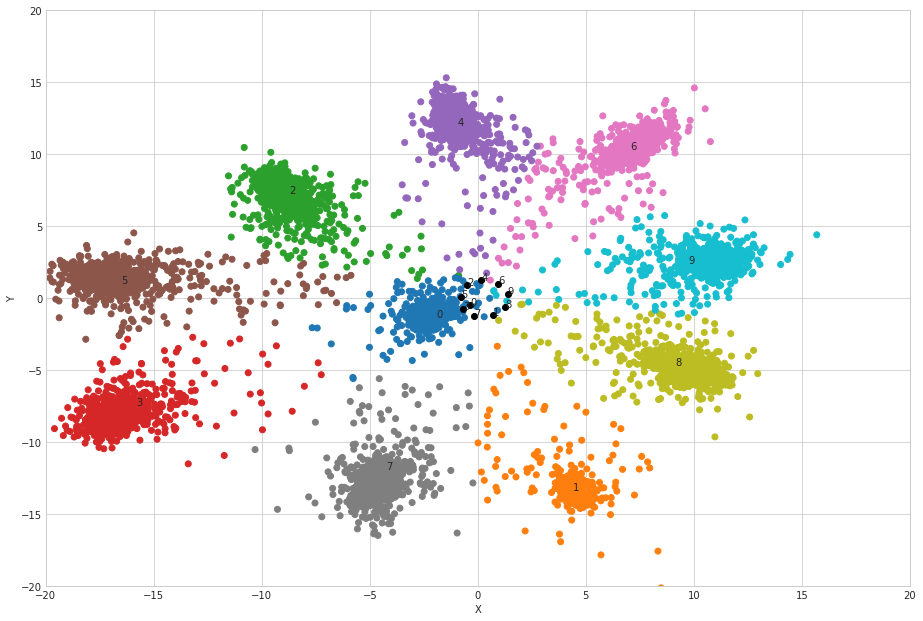

In [28]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)



class Plot_Report(object):
    def __init__(self, centers, class_vectors):
        self.fig = plt.figure()
        self.ax = self.fig.add_axes([-2,-2,2,2])
        self.centers = centers
        self.class_vectors = class_vectors
        self.center_names = ["0","1","2","3","4","5","6","7","8","9"]
        self.cmap = colors.ListedColormap(['#1f77b4', '#ff7f0e', 
                              '#2ca02c', '#d62728', 
                              '#9467bd', '#8c564b', 
                              '#e377c2', '#7f7f7f', 
                              '#bcbd22', '#17becf'])
        #self.cmap = discrete_cmap(10, 'cubehelix')
        
    def plot_data(self,x,y,c):
        self.ax.scatter(x,y, c=c , cmap=self.cmap, vmin=0, vmax=9) #, c=1 cmap=cmap
        
    def plot_centers(self):
        self.ax.scatter(self.centers[:,0],self.centers[:,1], c=[i for i in range(10)] , cmap=self.cmap, vmin=0, vmax=9) #, c=1 cmap=cmap
        for i, txt in enumerate(self.center_names):
            self.ax.annotate(txt, (self.centers[i,0], self.centers[i,1]))
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
    def plot_class_vectors(self):
        self.ax.scatter(self.class_vectors[0],self.class_vectors[1], c="black")
        for i, txt in enumerate(self.center_names):
            self.ax.annotate(txt, (self.class_vectors[0,i], self.class_vectors[1,i]))
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        
    def show(self):
        plt.xlim(-20, 20)
        plt.ylim(-20, 20)
        plt.show()
        
myplot = Plot_Report(np.array(model.centers), model.out.weights[0].numpy())

myplot.plot_data(features[:,0],features[:,1],y_pred_label)
myplot.plot_centers()
myplot.plot_class_vectors()
myplot.show()

In [29]:
np.array(model.centers)

array([[ -1.9242867 ,  -1.2769696 ],
       [  4.4159355 , -13.351339  ],
       [ -8.732005  ,   7.309432  ],
       [-15.808876  ,  -7.420747  ],
       [ -0.93458784,  12.040671  ],
       [-16.497854  ,   1.0617944 ],
       [  7.046907  ,  10.372195  ],
       [ -4.2405353 , -11.8541565 ],
       [  9.1233015 ,  -4.6500025 ],
       [  9.741671  ,   2.439099  ]], dtype=float32)

In [53]:
#Classification vectors
cv_x = model.out.weights[0].numpy()[0]
cv_y = model.out.weights[0].numpy()[0]

In [58]:
model.out.weights[0]

<tf.Variable 'dense_3/kernel:0' shape=(2, 10) dtype=float32, numpy=
array([[ 0.88432413,  0.68028337, -0.6672186 ,  1.2843869 , -0.15179698,
         1.276881  ,  0.08845953, -1.0143772 ,  0.2778069 , -0.8433039 ],
       [-1.3016163 ,  1.279158  , -1.2335091 , -0.55072093,  1.2718129 ,
         0.6290787 , -1.4957021 , -0.35204726,  0.9666587 ,  0.6032002 ]],
      dtype=float32)>